In [14]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from sklearn.linear_model import Lasso
except Exception:
    Lasso = None
from pybaselines import Baseline
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["axes.grid"] = True


In [15]:
def list_doric_channels(path):
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]
        chans = []
        if "LockInAOUT02" in base:
            for k in base["LockInAOUT02"].keys():
                if k.startswith("AIN"):
                    chans.append(k)
        chans = sorted(chans)

        digital = []
        if "DigitalIO" in base:
            for k in base["DigitalIO"].keys():
                if k.startswith("DIO"):
                    digital.append(k)
        return chans, digital

def load_doric(path, channel="AIN01", signal_folder="LockInAOUT02", ref_folder="LockInAOUT01",
              trigger_name=None):
    """
    Returns dict with:
      time, sig465, ref405, fs, (optional) trig_time, trig
    """
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]

        sig = np.asarray(base[signal_folder][channel][()], float)
        ref = np.asarray(base[ref_folder][channel][()], float)

        # time: prefer the matching folder time if size matches
        t_sig = np.asarray(base[signal_folder]["Time"][()], float) if "Time" in base[signal_folder] else np.array([])
        t_ref = np.asarray(base[ref_folder]["Time"][()], float) if "Time" in base[ref_folder] else np.array([])

        if t_sig.size == sig.size:
            t = t_sig
        elif t_ref.size == sig.size:
            t = t_ref
        else:
            # fallback
            dt = np.nanmedian(np.diff(t_sig)) if t_sig.size > 2 else 1/1000
            t = np.arange(sig.size) * dt

        # if ref length differs, interpolate onto t if possible
        if ref.size != sig.size:
            if t_ref.size == ref.size:
                ref = np.interp(t, t_ref, ref)
            else:
                ref = np.resize(ref, sig.size)

        # sampling rate
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan

        # optional digital trigger overlay
        trig_time = None
        trig = None
        if trigger_name:
            if "DigitalIO" in base and trigger_name in base["DigitalIO"]:
                dio = base["DigitalIO"]
                trig = np.asarray(dio[trigger_name][()], float)
                trig_time = np.asarray(dio["Time"][()], float) if "Time" in dio else None

                # if lengths mismatch, interpolate signals to trigger time (like your Doric logic)
                if trig_time is not None and trig_time.size and trig_time.size != t.size:
                    sig = np.interp(trig_time, t, sig)
                    ref = np.interp(trig_time, t, ref)
                    t = trig_time
                    fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else fs

    out = {"time": t, "sig465": sig, "ref405": ref, "fs": fs}
    if trig is not None and trig_time is not None:
        out["trig_time"] = trig_time
        out["trig"] = trig
    return out


In [16]:
# Set this to your file
path = r"C:\Analysis\fiber_photometry_app\test_data\30545-lick_0002.doric"

channels, dio = list_doric_channels(path)
channels, dio


(['AIN01'], ['DIO01', 'DIO02'])

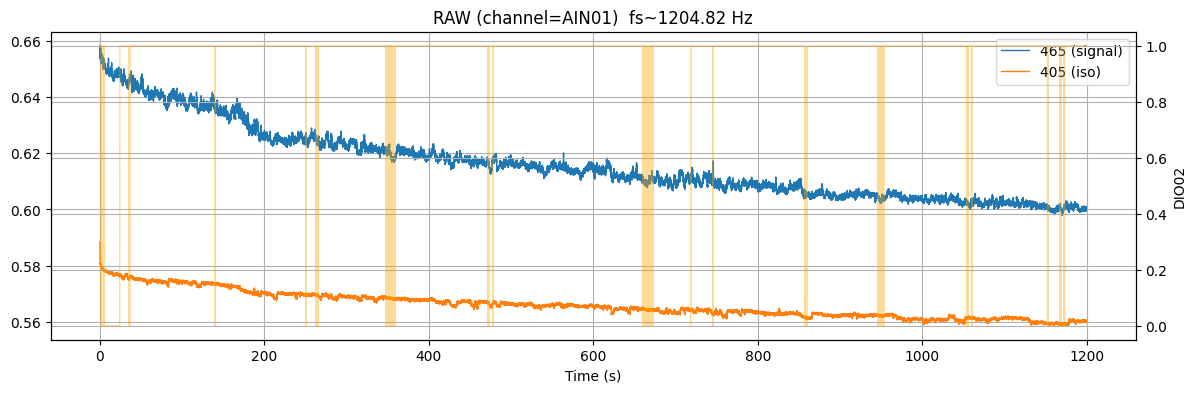

In [17]:
channel = channels[0] if channels else "AIN01"
trigger_name = dio[1] if dio else None  # or set to "DIO01", or None

data = load_doric(path, channel=channel, trigger_name=trigger_name)
t = data["time"]; sig = data["sig465"]; ref = data["ref405"]; fs = data["fs"]

fig, ax = plt.subplots()
ax.plot(t, sig, label="465 (signal)", lw=1)
ax.plot(t, ref, label="405 (iso)", lw=1)
ax.set_title(f"RAW (channel={channel})  fs~{fs:.2f} Hz")
ax.set_xlabel("Time (s)")
ax.legend(loc="upper right")

if "trig" in data:
    ax2 = ax.twinx()
    ax2.plot(data["trig_time"], data["trig"], color="orange", alpha=0.4, lw=1)
    ax2.set_ylabel(trigger_name)

plt.show()


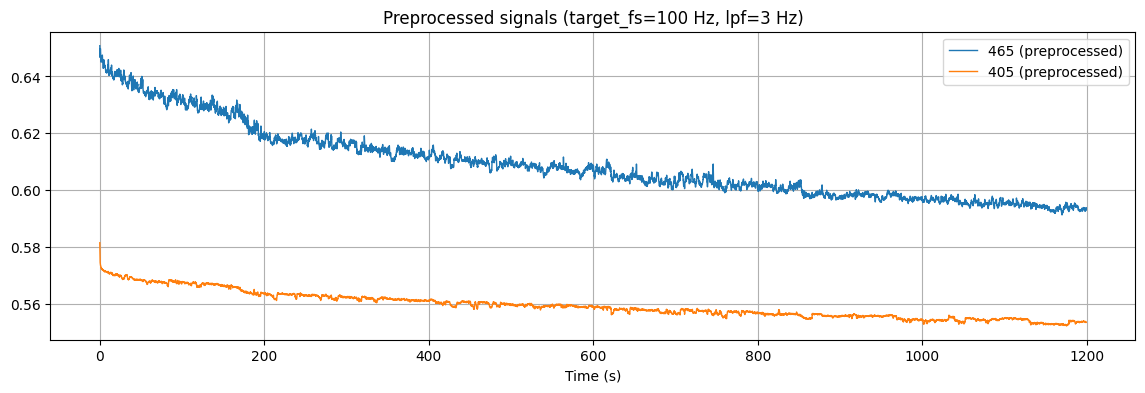

In [75]:

from scipy.signal import butter, filtfilt, decimate

def preprocess_signal(sig, fs_raw, target_fs=100, lpf_cutoff=3):
    """
    1\) Low-pass filter (Butterworth, lpf_cutoff Hz)
    2\) Decimate to target sampling rate (target_fs Hz)
    """
    nyquist = 0.5 * fs_raw
    normal_cutoff = lpf_cutoff / nyquist
    b, a = butter(N=2, Wn=normal_cutoff, btype="low", analog=False)
    sig_filtered = filtfilt(b, a, sig)

    q = int(fs_raw / target_fs)
    if q > 1:
        sig_downsampled = decimate(sig_filtered, q)
        real_fs = fs_raw / q
    else:
        sig_downsampled = sig_filtered
        real_fs = fs_raw

    return sig_downsampled, real_fs

# assumes you already have:
# t, sig, ref, fs from your loader cell

# preprocess both channels with the same target fs
target_fs = 100
lpf_cutoff = 3

sig_f, fs_sig = preprocess_signal(sig, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)
ref_f, fs_ref = preprocess_signal(ref, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)

# build downsampled time vector (use averaged fs of the two, or fs_sig)
fs_ds = fs_sig
dt_ds = 1.0 / fs_ds
t_ds = np.arange(sig_f.size) * dt_ds

fig, ax = plt.subplots()
ax.plot(t_ds, sig_f, lw=1, label="465 (preprocessed)")
ax.plot(t_ds, ref_f, lw=1, label="405 (preprocessed)")
ax.set_title(f"Preprocessed signals (target_fs={target_fs} Hz, lpf={lpf_cutoff} Hz)")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()

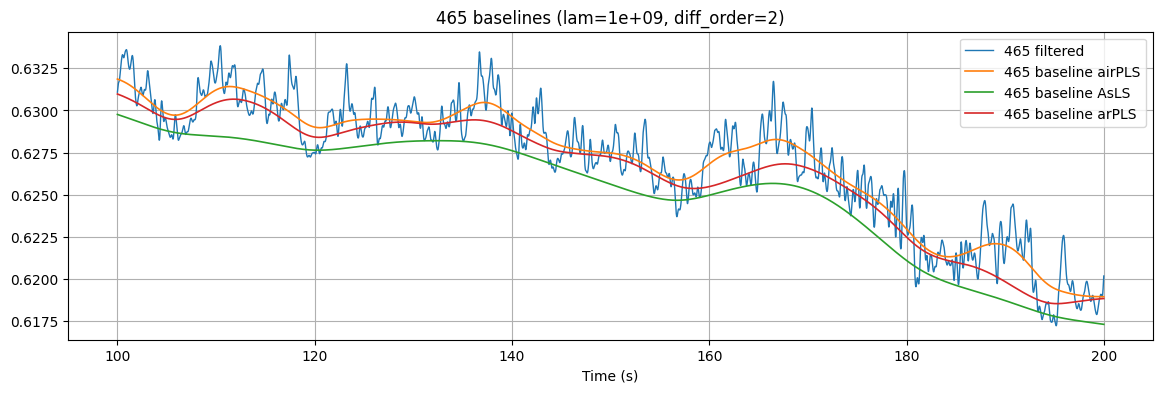

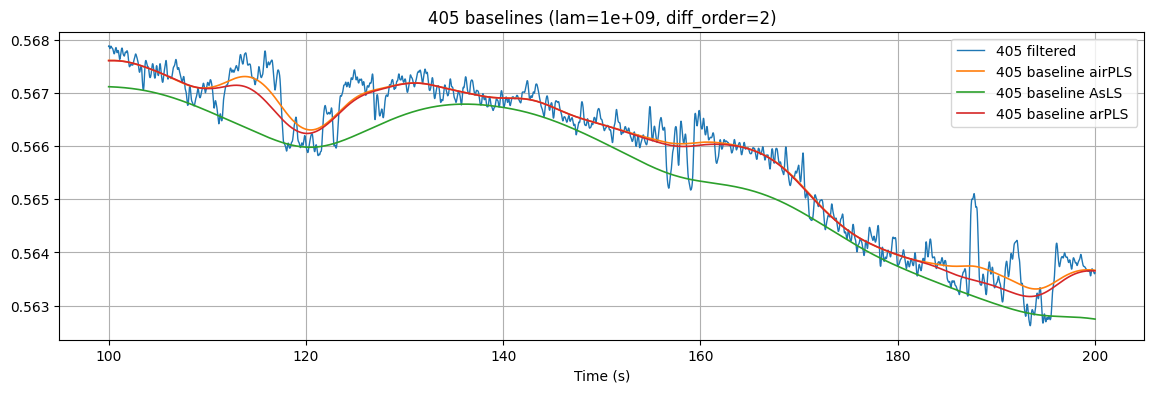

In [79]:


# set to None to use full range; otherwise set in seconds, e.g. 10.0, 60.0
t_min = 100
t_max = 200

# build mask for the selected time window
if t_min is None:
    t_min = np.nanmin(t_ds)
if t_max is None:
    t_max = np.nanmax(t_ds)

mask = (t_ds >= t_min) & (t_ds <= t_max)

baseline_fitter = Baseline(x_data=t_ds)

lam = 1e9        # try 1e5 → 1e8 depending on drift timescale
diff_order = 2
max_iter = 50
tol = 1e-3

# --- compute baselines on full-length data ---

# airPLS baselines
b_sig_air, p_sig_air = baseline_fitter.airpls(
    sig_f, lam=lam, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)
b_ref_air, p_ref_air = baseline_fitter.airpls(
    ref_f, lam=lam, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)

# AsLS baselines
b_sig_asls, _ = baseline_fitter.asls(
    sig_f, lam=lam, p=0.01, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)
b_ref_asls, _ = baseline_fitter.asls(
    ref_f, lam=lam, p=0.01, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)

# arPLS baselines
b_sig_arpls, _ = baseline_fitter.arpls(
    sig_f, lam=lam, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)
b_ref_arpls, _ = baseline_fitter.arpls(
    ref_f, lam=lam, diff_order=diff_order,
    max_iter=max_iter, tol=tol
)

# slice time and signals for plotting
t_plot = t_ds[mask]
sig_f_plot = sig_f[mask]
ref_f_plot = ref_f[mask]

b_sig_air_plot = b_sig_air[mask]
b_sig_asls_plot = b_sig_asls[mask]
b_sig_arpls_plot = b_sig_arpls[mask]

b_ref_air_plot = b_ref_air[mask]
b_ref_asls_plot = b_ref_asls[mask]
b_ref_arpls_plot = b_ref_arpls[mask]

# --- plot 465 signal with its three baselines ---
fig_sig, ax_sig = plt.subplots()
ax_sig.plot(t_plot, sig_f_plot, lw=1, label="465 filtered")
ax_sig.plot(t_plot, b_sig_air_plot, lw=1.2, label="465 baseline airPLS")
ax_sig.plot(t_plot, b_sig_asls_plot, lw=1.2, label="465 baseline AsLS")
ax_sig.plot(t_plot, b_sig_arpls_plot, lw=1.2, label="465 baseline arPLS")
ax_sig.set_title(f"465 baselines (lam={lam:.0e}, diff_order={diff_order})")
ax_sig.set_xlabel("Time (s)")
ax_sig.legend()
plt.show()

# --- plot 405 reference with its three baselines ---
fig_ref, ax_ref = plt.subplots()
ax_ref.plot(t_plot, ref_f_plot, lw=1, label="405 filtered")
ax_ref.plot(t_plot, b_ref_air_plot, lw=1.2, label="405 baseline airPLS")
ax_ref.plot(t_plot, b_ref_asls_plot, lw=1.2, label="405 baseline AsLS")
ax_ref.plot(t_plot, b_ref_arpls_plot, lw=1.2, label="405 baseline arPLS")
ax_ref.set_title(f"405 baselines (lam={lam:.0e}, diff_order={diff_order})")
ax_ref.set_xlabel("Time (s)")
ax_ref.legend()
plt.show()

In [80]:
import numpy as np

def ols_fit(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if np.sum(m) < 10:
        return 1.0, 0.0
    X = np.vstack([x[m], np.ones(np.sum(m))]).T
    coef, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    return float(coef[0]), float(coef[1])

def compute_motion_corrected_dff(sig_f, ref_f, b_sig, b_ref):
    """
    Computes motion-corrected dF/F using the 'Standardized' method:
    1) Calculate dF/F for both signal and reference channels separately.
       dff_sig_raw = (sig - b_sig) / b_sig
       dff_ref_raw = (ref - b_ref) / b_ref
    2) Fit dff_ref_raw to dff_sig_raw using OLS (y = ax + b).
    3) Subtract the fitted reference from the signal dF/F.
       dff_mc = dff_sig_raw - (a * dff_ref_raw + b)
    """

    # --- 1. Calculate raw dF/F for each channel ---
    # Prepare denominators (avoid division by zero)
    den_sig = np.asarray(b_sig, float).copy()
    den_sig[np.abs(den_sig) < 1e-12] = np.nan

    den_ref = np.asarray(b_ref, float).copy()
    den_ref[np.abs(den_ref) < 1e-12] = np.nan

    # Calculate standard dF/F (percent change) for each
    dff_sig_raw = (sig_f - b_sig) / den_sig
    dff_ref_raw = (ref_f - b_ref) / den_ref

    # --- 2. Fit Reference dF/F to Signal dF/F ---
    # We fit: dff_sig_raw ~ a * dff_ref_raw + b
    a, b = ols_fit(dff_ref_raw, dff_sig_raw)

    # --- 3. Subtract to get Motion-Corrected dF/F ---
    # The fitted reference represents the motion/artifact component in dF/F space
    fitted_ref = (a * dff_ref_raw + b)
    dff_mc = dff_sig_raw - fitted_ref

    # Return dictionary with keys compatible with your analysis pipeline
    # Note: 'sig_det' and 'ref_det' now refer to the raw dF/F traces
    return {
        "sig_det": dff_sig_raw,   # Now holds raw dF/F of signal
        "ref_det": dff_ref_raw,   # Now holds raw dF/F of reference
        "a": a,                   # Slope of the regression in dF/F space
        "b": b,                   # Intercept of the regression
        "delta_mc": dff_mc,       # The final motion-corrected dF/F
        "dff": dff_mc,            # Same as delta_mc (kept for compatibility)
    }

# Compute motion-corrected outputs for each method
out_air  = compute_motion_corrected_dff(sig_f, ref_f, b_sig_air,  b_ref_air)
out_asls = compute_motion_corrected_dff(sig_f, ref_f, b_sig_asls, b_ref_asls)
out_arpls= compute_motion_corrected_dff(sig_f, ref_f, b_sig_arpls,b_ref_arpls)

print("OLS fits (sig_det ~ a*ref_det + b)")
print(f"airPLS : a={out_air['a']:.4f}, b={out_air['b']:.4f}")
print(f"AsLS   : a={out_asls['a']:.4f}, b={out_asls['b']:.4f}")
print(f"arPLS  : a={out_arpls['a']:.4f}, b={out_arpls['b']:.4f}")


OLS fits (sig_det ~ a*ref_det + b)
airPLS : a=0.6952, b=-0.0000
AsLS   : a=0.6491, b=0.0017
arPLS  : a=0.8702, b=0.0004


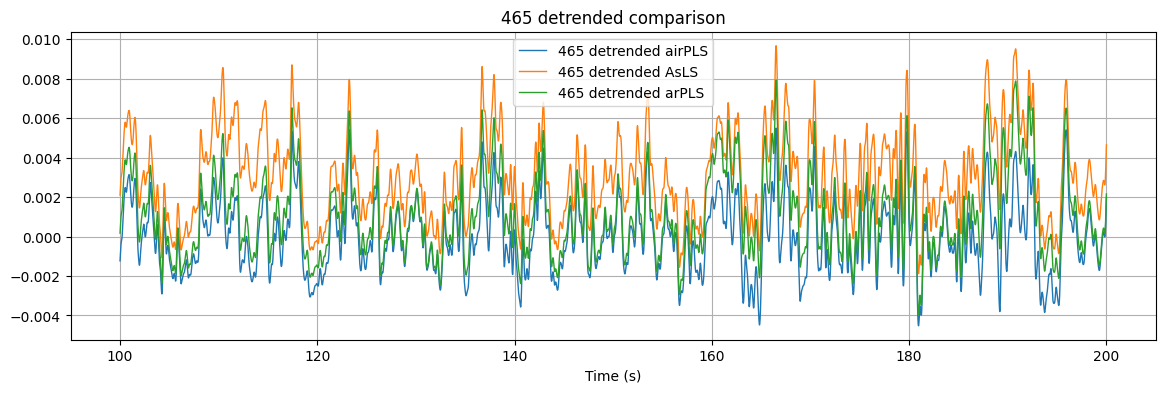

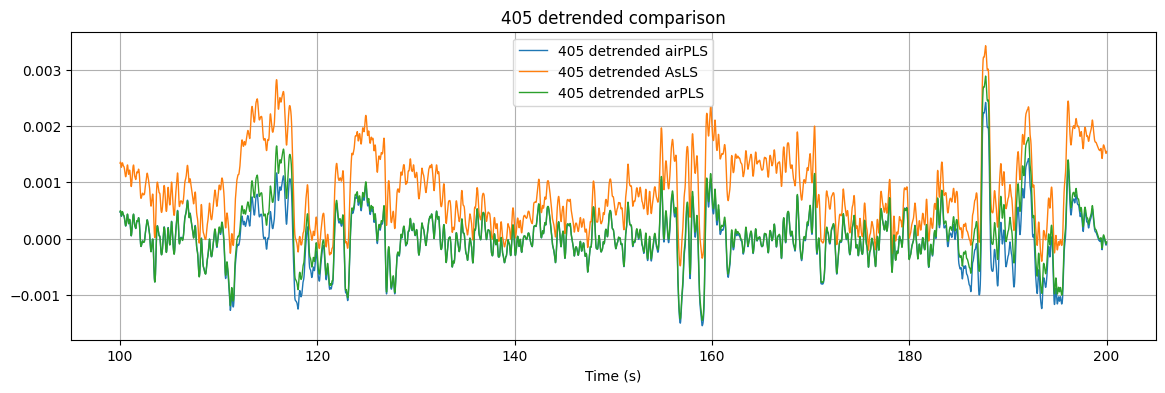

In [82]:
# slice for plotting
t_plot = t_ds[mask]

def sl(x):  # slice helper
    return np.asarray(x)[mask]

fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["sig_det"]),  lw=1, label="465 detrended airPLS")
ax.plot(t_plot, sl(out_asls["sig_det"]), lw=1, label="465 detrended AsLS")
ax.plot(t_plot, sl(out_arpls["sig_det"]),lw=1, label="465 detrended arPLS")
ax.set_title("465 detrended comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["ref_det"]),  lw=1, label="405 detrended airPLS")
ax.plot(t_plot, sl(out_asls["ref_det"]), lw=1, label="405 detrended AsLS")
ax.plot(t_plot, sl(out_arpls["ref_det"]),lw=1, label="405 detrended arPLS")
ax.set_title("405 detrended comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


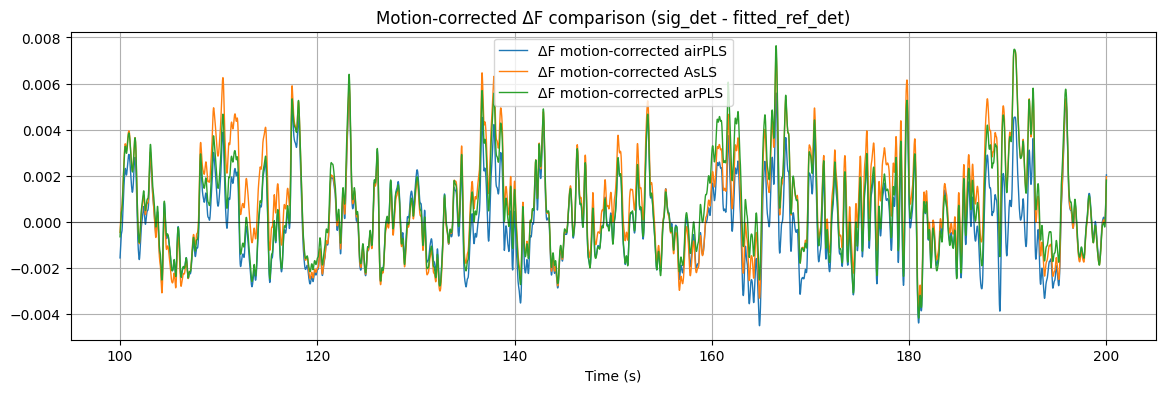

In [83]:
fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["delta_mc"]),  lw=1, label="ΔF motion-corrected airPLS")
ax.plot(t_plot, sl(out_asls["delta_mc"]), lw=1, label="ΔF motion-corrected AsLS")
ax.plot(t_plot, sl(out_arpls["delta_mc"]),lw=1, label="ΔF motion-corrected arPLS")
ax.axhline(0, color="k", lw=0.8, alpha=0.5)
ax.set_title("Motion-corrected ΔF comparison (sig_det - fitted_ref_det)")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


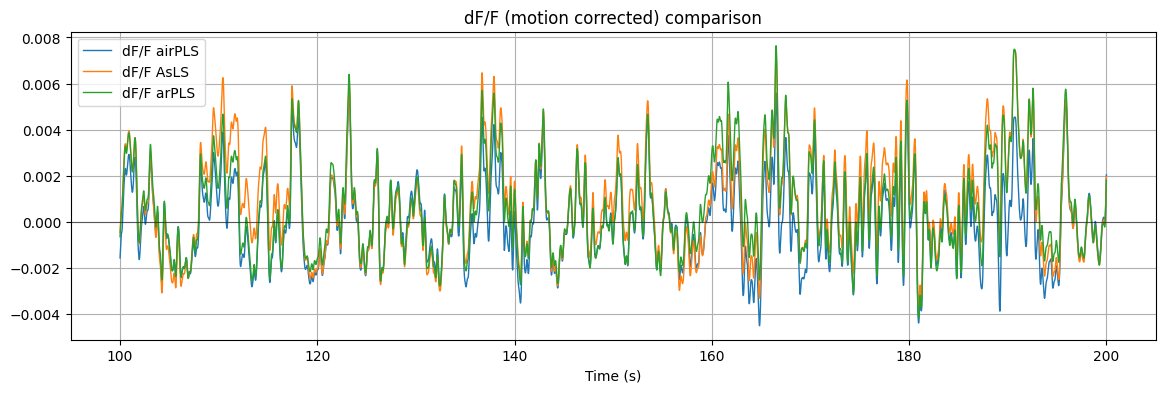

In [84]:
fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["dff"]),  lw=1, label="dF/F airPLS")
ax.plot(t_plot, sl(out_asls["dff"]), lw=1, label="dF/F AsLS")
ax.plot(t_plot, sl(out_arpls["dff"]),lw=1, label="dF/F arPLS")
ax.axhline(0, color="k", lw=0.8, alpha=0.5)
ax.set_title("dF/F (motion corrected) comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


In [85]:
def rms(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    return float(np.sqrt(np.mean(x**2))) if x.size else np.nan

def corr(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    if np.sum(m) < 10:
        return np.nan
    aa = a[m] - np.mean(a[m])
    bb = b[m] - np.mean(b[m])
    denom = np.sqrt(np.sum(aa**2) * np.sum(bb**2))
    return float(np.sum(aa*bb) / denom) if denom > 0 else np.nan

d_air  = sl(out_air["dff"])
d_asls = sl(out_asls["dff"])
d_arpls= sl(out_arpls["dff"])

print("Windowed dF/F metrics:")
print("RMS:", "airPLS", rms(d_air), "AsLS", rms(d_asls), "arPLS", rms(d_arpls))
print("corr(air, asls) =", corr(d_air, d_asls))
print("corr(air, arpls)=", corr(d_air, d_arpls))
print("corr(asls, arpls)=", corr(d_asls, d_arpls))


Windowed dF/F metrics:
RMS: airPLS 0.0017510362873541093 AsLS 0.0022508290323248912 arPLS 0.002100974973815439
corr(air, asls) = 0.9226048795881723
corr(air, arpls)= 0.9308502240798334
corr(asls, arpls)= 0.9488152792277463
